<div align="center">
  <img src="Images/image2.jpg" alt="Logo" width="500">
  <h1 style="font-size: 40px; text-decoration: underline;">IDUMP TRASH IMAGE CLASSIFICATION</h1>
</div>


***
## BUSINESS UNDERSTANDING
***
### Overview/Background Information

Konza City Technopolis is a burgeoning smart city in Kenya, designed to be a hub of technology, innovation, and sustainability. As part of its commitment to environmental sustainability, Konza City aims to implement advanced waste management solutions. iDump, a waste management company, has been contracted to develop and deploy an efficient waste segregation system that separates waste into different categories for recycling. This initiative will play a crucial role in maintaining the city’s cleanliness, reducing environmental impact, and promoting recycling practices.

Detection of the waste types under meticulously refined material classes in both an accurate and timely manner is essential for sustainable waste management, ensuring accountability for both seasonal variations and recycling uptake.

### Problem Statement

![Problematic Garbage Disposal](Images\landfill.jpeg)

Konza City Technopolis faces significant challenges in managing the diverse and large volume of waste generated by its residents and businesses, projected to peak at 240,000 inhabitants. Traditional waste management methods, reliant on manual sorting and segregation, have proven to be inefficient, labor-intensive, and unable to cope with the scale of waste produced. This inefficiency has led to increased environmental pollution, with a substantial portion of waste being improperly disposed of in landfills or open dumps, contributing to soil contamination, water pollution, and increased greenhouse gas emissions. Furthermore, the lack of effective segregation and recycling facilities hampers the city’s ability to recycle valuable materials, leading to significant loss of resources and economic opportunities.


### Metrics of Success:
- **Model Accuracy:** We aim for at least 80% accuracy in waste classification.
- **F1 Score:** We’ve set a target F1 score of 0.75 or higher to balance precision and recall.

### Objectives

**Main Objective:** Develop and deploy a robust image recognition system to enhance waste management efficiency in Konza City.

**Specific Objectives:**
1. Gather and preprocess a diverse dataset of waste images to ensure robust model training, including various types and conditions of waste items.
2. Analyze and report the most common types of waste collected.
3. Accurately classify waste into their distinct material types and categorize them into recyclable inorganics, divertible organics, and non-recyclable inorganic materials to improve waste management.
4. Deploy a user-friendly interface that allows iDump personnel/equipment to upload images and receive real-time classification results from the image recognition model.





***
## DATA UNDERSTANDING
***

The data used was sourced from [kaggle.com](https://www.kaggle.com/datasets/joebeachcapital/realwaste). The color images of waste items was captured at the point of reception in a landfill environment and was further evaluated as follows:
- > 1. Image Loading and Summary
- > 2. Visualization of Images
- > 3. Check Image DImensions
- > 4. Check for corrupted Images
- > 5. Check for duplicates

In [1]:
# Libraries used 
import os
import random
import shutil
import pickle
import imagehash
import warnings
import numpy as np
import pandas as pd
import splitfolders
import tensorflow as tf
from   pathlib import Path
warnings.filterwarnings("ignore")

# Libraries for visualizations
import matplotlib.pyplot as plt
from   PIL import Image
from   tensorflow.keras.utils import  img_to_array, load_img

# Libraries for Model Preprocessing
from   tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
class DataUnderstanding:
    """
    Class to perform data understanding on the images provided and pickle images to be used for deployment
    """
    def __init__(self, path):
        self.path = path 
        self.folders = []  
        self.results = None
        self.corrupt_images = []

    def data_summary(self):
        """
        Locate directory names in path and return the data in a dataframe
        and count of images in each directory 
        """
        main_folder_path = Path(self.path)
        all_folders = [d for d in main_folder_path.glob('**/') if d.is_dir()]
        self.folders = [folder.name for folder in all_folders if folder.name != main_folder_path.name]
        
        data = [] 
        for folder in all_folders:
            folder_name = folder.name
            images_count = len(list(folder.glob('*.*')))
            if folder_name != main_folder_path.name: 
                data.append({
                    'Folder Name': folder_name,
                    'Images Count': images_count,  
                    'Folder Location': folder
                })
        
        self.results = pd.DataFrame(data)
        print("-------------------------------------------")
        print("DATA PREVIEW")
        print("-------------------------------------------")
        display(self.results)

        print("-------------------------------------------")
        print("LIST OF CLASSES")
        print("-------------------------------------------")
        print(list(self.results["Folder Name"]))

        total_images_count = self.results['Images Count'].sum()
        total_class_count = self.results["Folder Name"].count()
        print("-------------------------------------------")
        print("COLUMN COUNTS")
        print("-------------------------------------------")
        print(f'Total Class Count: {total_class_count} classes')
        print(f'Total Images Count: {total_images_count} images')
        return self.results

    def visualize_and_pickle(self, top=5, output_folder='Pickle_files/images'):
        """
        Visualize and pickle the images generated from the random visuals
        """
        print("The following dataset has", len(self.folders), " Classes with sample images as below:")
        print("\n")
        
        # Ensure output directory exists
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)
        
        all_images = {}
        for subdir in self.folders:
            dir_path = Path(self.path) / subdir
            if dir_path.is_dir():
                all_item_files = os.listdir(dir_path)
                if len(all_item_files) < top:
                    top = len(all_item_files)
                item_files = random.sample(all_item_files, top)
                item_files = [os.path.join(dir_path, file) for file in item_files]
                
                cols = 5
                rows = (top // cols) + (top % cols > 0)
                plt.figure(figsize=(15, 3 * rows))
                images = []
                for idx, img_path in enumerate(item_files):
                    plt.subplot(rows, cols, idx + 1)
                    img = plt.imread(img_path)
                    images.append(img_path)
                    plt.imshow(img)
                    plt.axis('off')
                    plt.title(os.path.basename(subdir))
                
                plt.tight_layout()
                plt.show()
                
                all_images[subdir] = images
                
                # Pickle the image paths
                output_file = os.path.join(output_folder, f"{subdir}_images.pkl")
                with open(output_file, 'wb') as f:
                    pickle.dump(images, f)
                print(f"Pickled images for class {subdir} to {output_file}")

        

    def image_dimensions(self):
        """
        Check for image dimensions of all images, returned as a histplot and in a dataframe
        """
        image_sizes = []
        for folder in self.results['Folder Location']:
            for image_file in folder.glob('*.*'):
                try:
                    with Image.open(image_file) as img:
                        image_sizes.append(img.size)
                except Exception as e:
                    print(f"Error loading image {image_file}: {e}")

        df_sizes = pd.DataFrame(image_sizes, columns=['Width', 'Height'])

        # Plot histograms of image dimensions
        df_sizes.hist(bins=50, figsize=(10, 5))
        plt.suptitle('Image Dimensions Distribution')
        plt.show()

        return df_sizes.head()

    def corrupted_images(self):
        """ 
        Checking for any corrupted images in the file path
        """
        corrupt_images = []
        for folder in self.results['Folder Location']:
            for image_file in folder.glob('*.*'):
                try:
                    with Image.open(image_file) as img:
                        img.verify()  
                except (IOError, SyntaxError) as e:
                    corrupt_images.append(image_file)
        
        self.corrupt_images = corrupt_images
        if len(corrupt_images)>0:
            print(f"Corrupt images: {len(corrupt_images)}")
        else:
            print(" NO CORRUPTED IMAGES FOUND")
    
    def duplicates(self):
        """
        Detecting duplicated images based on perceptual hash.
        """
        image_hashes = {}
        duplicates = []

        for folder in self.results['Folder Location']:
            for image_file in folder.glob('*.*'):
                try:
                    with Image.open(image_file) as img:
                        img_hash = imagehash.phash(img)
                        if img_hash in image_hashes:
                            duplicates.append((image_file, image_hashes[img_hash]))
                        else:
                            image_hashes[img_hash] = image_file
                except Exception as e:
                    print(f"Error processing image {image_file}: {e}")

        if duplicates:
            print(f"Found {len(duplicates)} duplicate images:")
            for dup in duplicates:
                print(f"Duplicate: {dup[0]} and {dup[1]}")
        else:
            print("NO DUPLICATE IMAGES FOUND")


**Image Loading and Summary**


In [3]:
# Instantiate the DataUnderstanding Class
data=DataUnderstanding("RealWaste")

# Combining the images to get a summary/overview
df=data.data_summary()

-------------------------------------------
DATA PREVIEW
-------------------------------------------


Folder Name  Images Count                Folder Location
0        Food Organics           411        RealWaste\Food Organics
1                Glass           420                RealWaste\Glass
2                Metal           790                RealWaste\Metal
3  Miscellaneous Trash           495  RealWaste\Miscellaneous Trash
4                Paper           500                RealWaste\Paper
5              Plastic           921              RealWaste\Plastic
6        Textile Trash           318        RealWaste\Textile Trash
7           Vegetation           436           RealWaste\Vegetation

-------------------------------------------
LIST OF CLASSES
-------------------------------------------
['Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
-------------------------------------------
COLUMN COUNTS
-------------------------------------------
Total Class Count: 8 classes
Total Images Count: 4291 images



**Visualization of Images**

The following dataset has 8  Classes with sample images as below:




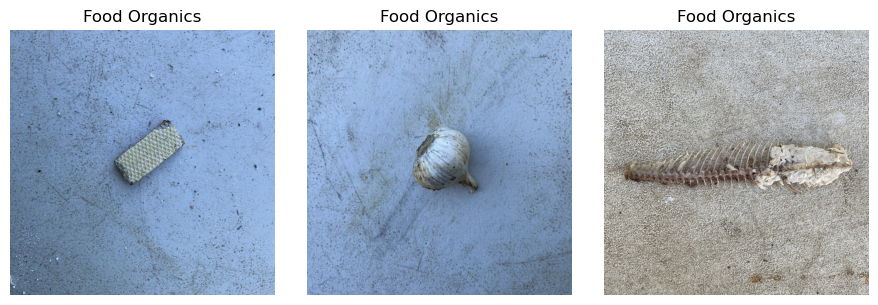

Pickled images for class Food Organics to Pickle_files/images\Food Organics_images.pkl


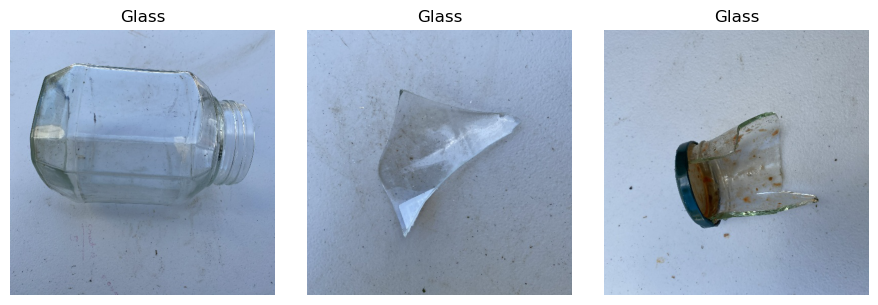

Pickled images for class Glass to Pickle_files/images\Glass_images.pkl


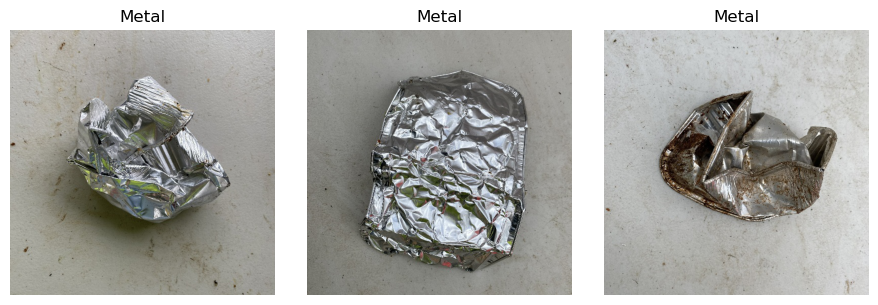

Pickled images for class Metal to Pickle_files/images\Metal_images.pkl


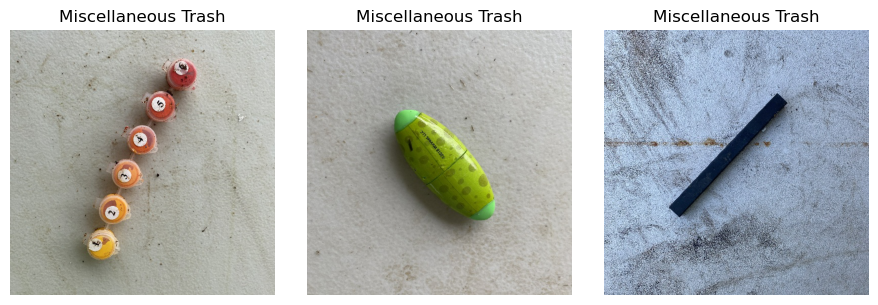

Pickled images for class Miscellaneous Trash to Pickle_files/images\Miscellaneous Trash_images.pkl


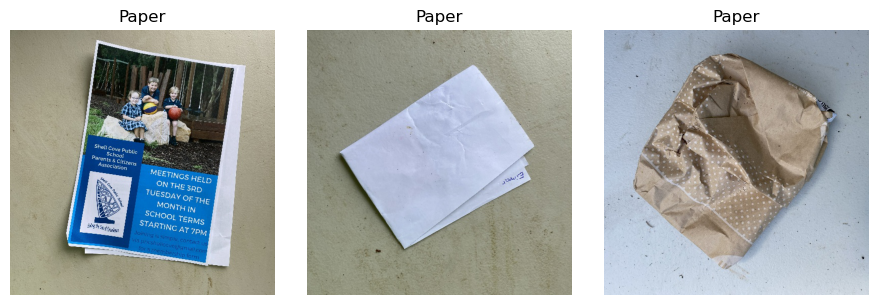

Pickled images for class Paper to Pickle_files/images\Paper_images.pkl


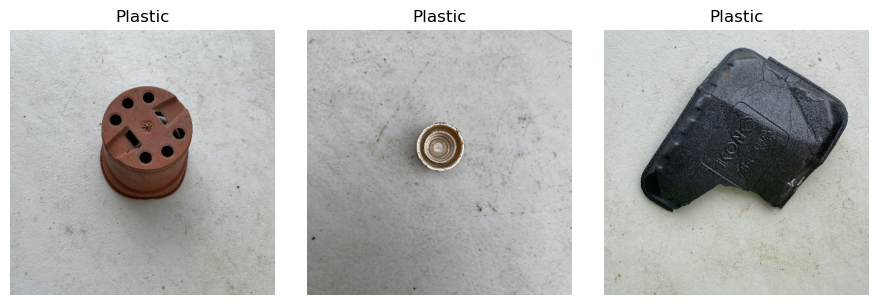

Pickled images for class Plastic to Pickle_files/images\Plastic_images.pkl


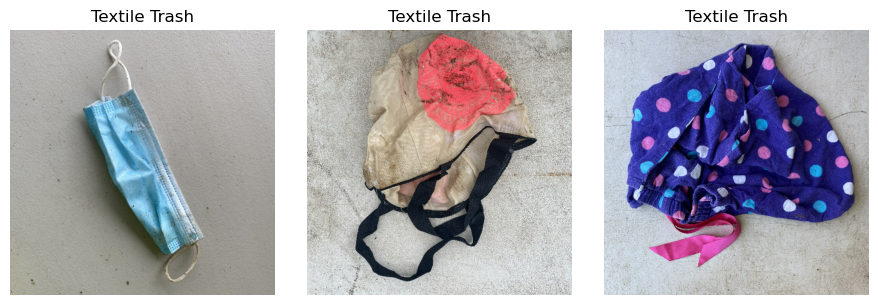

Pickled images for class Textile Trash to Pickle_files/images\Textile Trash_images.pkl


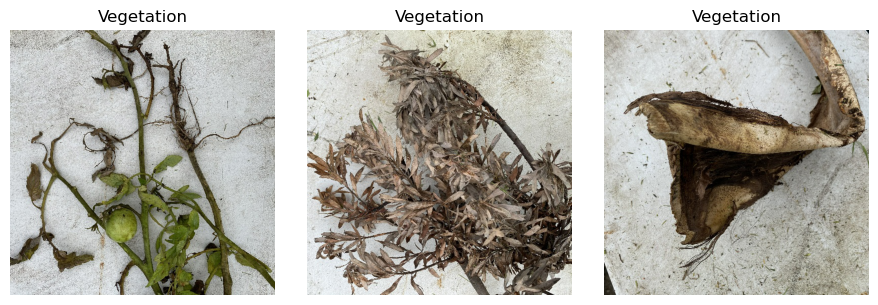

Pickled images for class Vegetation to Pickle_files/images\Vegetation_images.pkl


In [4]:
# plotting random images from each class to understand the images and pickling images for future use
data.visualize_and_pickle(top=3)


**Check Image DImensions**


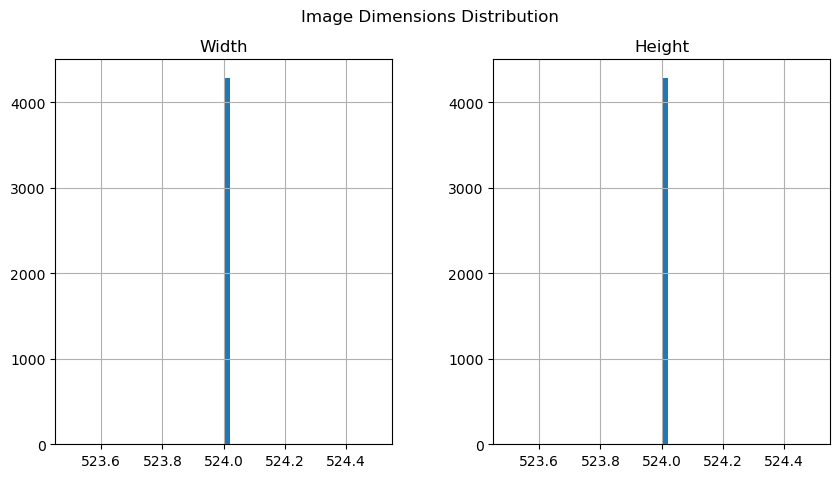

Width  Height
0    524     524
1    524     524
2    524     524
3    524     524
4    524     524

In [5]:
# check the resolution of the images
data.image_dimensions()


**Check for corrupted Images**


In [6]:
# Check for corrupted images 
data.corrupted_images()

 NO CORRUPTED IMAGES FOUND


**Check for duplicates**

In [7]:
# Check for duplicated images
data.duplicates()

NO DUPLICATE IMAGES FOUND


***
**Observations:**
***
- >The data has 8 classes and  4291 images. the classes are paper, plastic, metals, textiles, food organics, glass, vegetation and miscellaneous trash.
- >The images all have a resolution of 524x524.
- >There are no corrupted images present in the data.
- >There are no duplicated images. 

***
## DATA PREPARATION
***
In preparation for data classification modelling the following steps below were performed to ensure the data was ready.

### Class Distribution Check
Performed to check for class imbalance

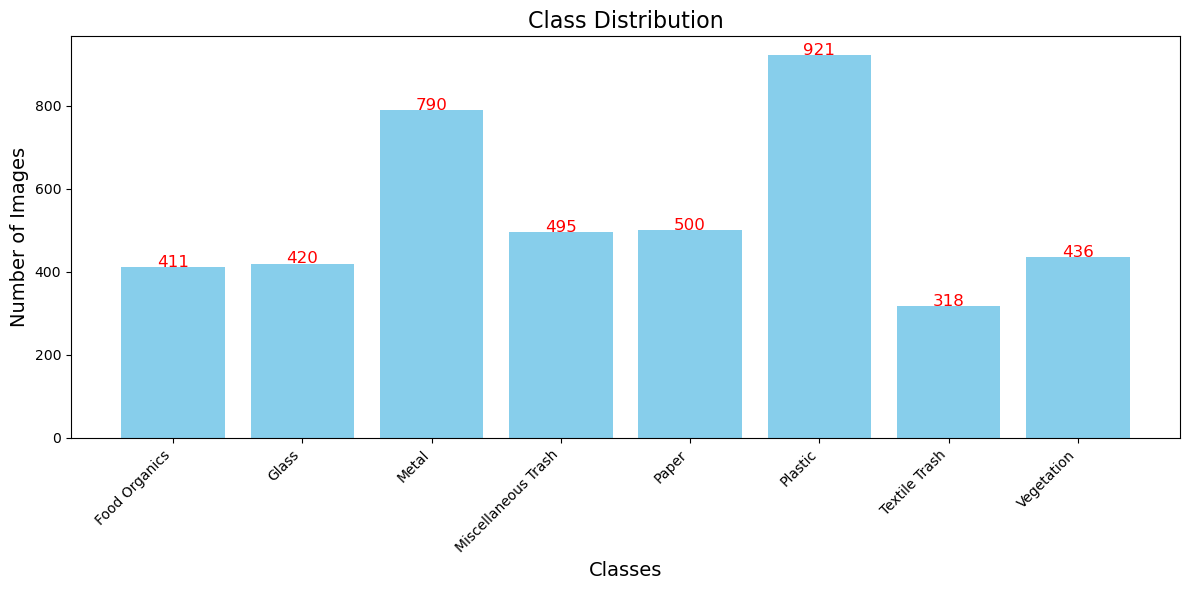

In [12]:
#Checking the class distribution
plt.figure(figsize=(12, 6))
plt.bar(df['Folder Name'], df['Images Count'], color='skyblue')
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)
plt.title('Class Distribution', fontsize=16)
plt.xticks(rotation=45, ha='right')
    
# Add value labels on top of the bars
for i, count in enumerate(df['Images Count']):
    plt.text(i, count + 0.5, str(count), ha='center', color='red', fontsize=12)
    
plt.tight_layout()
plt.show()


***
**Observations**
***
- >There is a noticeable imbalance in the number of images per class.
- >Plastic and Metal have significantly more images compared to other classes.
- >Textile Trash has the fewest images, which could make it underrepresented in the dataset.

### Splitting The Data
Performed to split the data for training, validation and testing


In [ ]:
# Splitting the data into train, test and validation
input_folder = 'RealWaste'
splitfolders.ratio(input_folder,output = 'RealWaste2',seed = 42,ratio = (.7,.2,.1),group_prefix=None)



Copying files: 4291 files [00:28, 148.33 files/s]


In [ ]:
# Function to check the counts in each dataset
def print_image_counts(directory):
    for subdir, _, files in os.walk(directory):
        # Count images in the current subdirectory
        count = sum(1 for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg')))
        if count > 0: 
            print(f"Folder: {os.path.basename(subdir)}")
            print(f"Number of images: {count}")
# Paths to the split directories
train_dir = 'RealWaste2/train'
val_dir = 'RealWaste2/val'
test_dir = 'RealWaste2/test'

# Print image counts for each directory
print("Training Set:")
print_image_counts(train_dir)
print("\nValidation Set:")
print_image_counts(val_dir)
print("\nTest Set:")
print_image_counts(test_dir)

Training Set:
Folder: Food Organics
Number of images: 287
Folder: Glass
Number of images: 294
Folder: Metal
Number of images: 553
Folder: Miscellaneous Trash
Number of images: 346
Folder: Paper
Number of images: 350
Folder: Plastic
Number of images: 644
Folder: Textile Trash
Number of images: 222
Folder: Vegetation
Number of images: 305

Validation Set:
Folder: Food Organics
Number of images: 82
Folder: Glass
Number of images: 84
Folder: Metal
Number of images: 158
Folder: Miscellaneous Trash
Number of images: 99
Folder: Paper
Number of images: 100
Folder: Plastic
Number of images: 184
Folder: Textile Trash
Number of images: 63
Folder: Vegetation
Number of images: 87

Test Set:
Folder: Food Organics
Number of images: 42
Folder: Glass
Number of images: 42
Folder: Metal
Number of images: 79
Folder: Miscellaneous Trash
Number of images: 50
Folder: Paper
Number of images: 50
Folder: Plastic
Number of images: 93
Folder: Textile Trash
Number of images: 33
Folder: Vegetation
Number of images:

***
**Observations**
***
Training Set Size:
>Largest Class: Plastic with 644 images.

>Smallest Class: Textile Trash with 222 images.

Validation Set Size:
>Largest Class: Glass with 84 images.

>Smallest Class: Textile Trash with 63 images.

Test Set Size:
> Largest Class: Plastic with 93 images.

> Smallest Class: Textile Trash with 33 images.


***
### Data Augmentation
***
Performed to check how the augmentation shall occur to the images

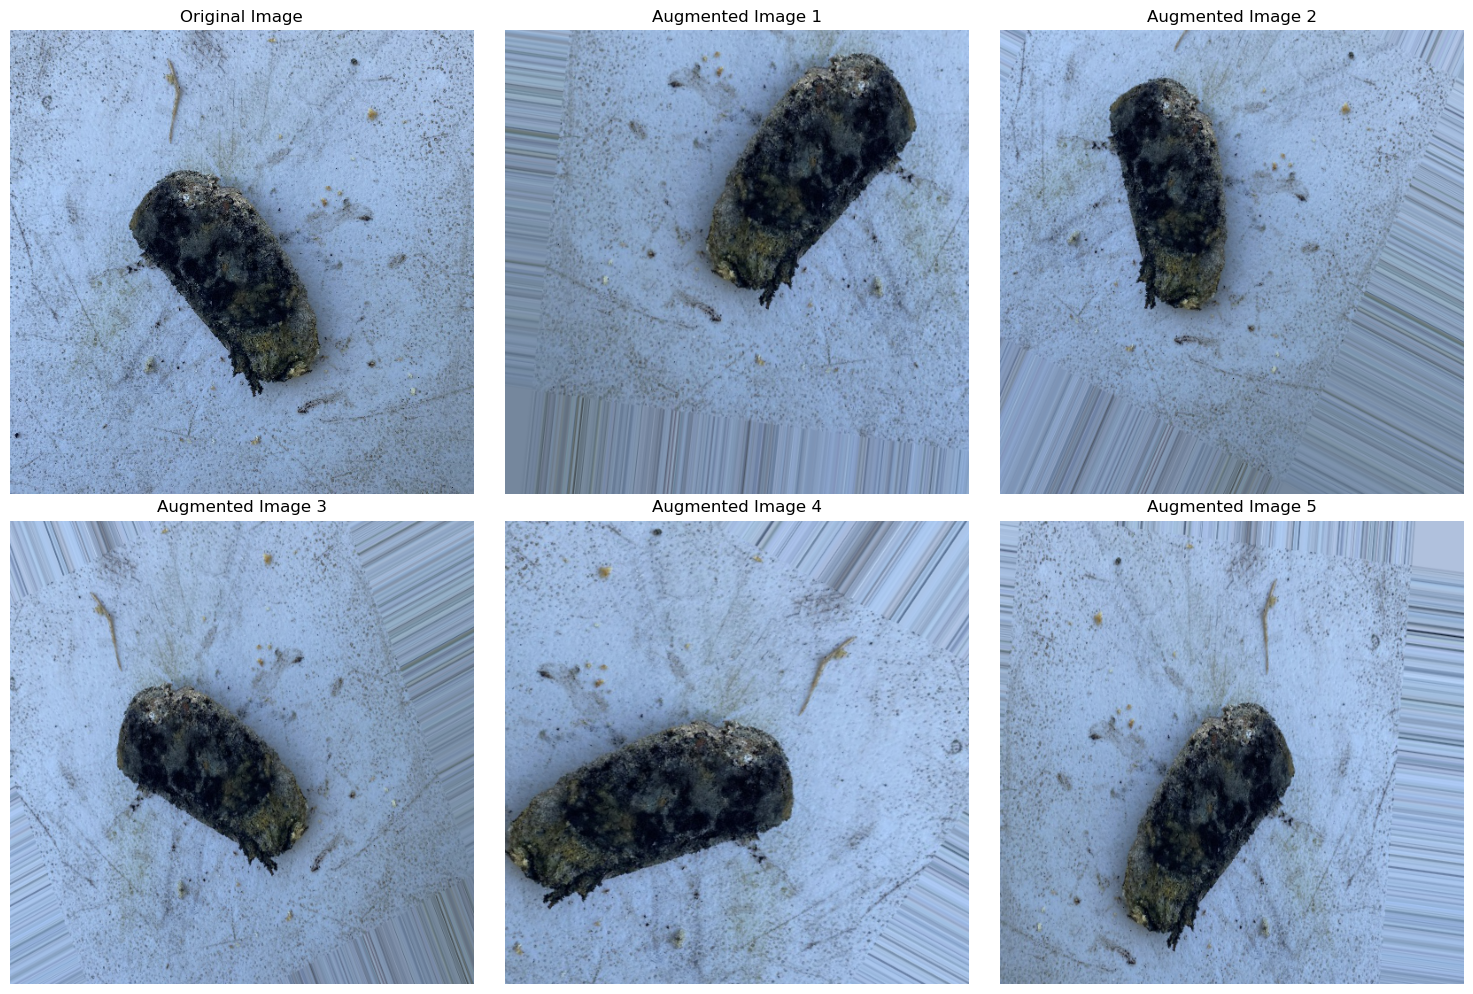

In [ ]:
# Path to the image
img_path = r'RealWaste2\val\Food Organics\Food Organics_42.jpg'

# Load and preprocess the image
img = load_img(img_path, target_size=(524, 524))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Set up the ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create the iterator
iterator = datagen.flow(img_array, batch_size=1)

# Generate augmented images
augmented_images = [next(iterator)[0].astype('uint8') for _ in range(5)]

# Plot the original image and augmented images
plt.figure(figsize=(15, 10))

# Original image
plt.subplot(2, 3, 1)
plt.imshow(img_array[0].astype('uint8'))
plt.title('Original Image')
plt.axis('off')

# Augmented images
for i, aug_img in enumerate(augmented_images):
    plt.subplot(2, 3, i + 2)
    plt.imshow(aug_img)
    plt.title(f'Augmented Image {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


***
**Observations**
***
- > The original image serves as a baseline, while the augmented images show various transformations applied. 
- > This includes rotations, shifts, shears, and zooms. 
- > The augmentations introduced significant variations, demonstrating how the data augmentation techniques can enrich the dataset by creating different views of the same image.